In [1]:
%matplotlib notebook
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import time

In [2]:
!ls -lrt /data/craco/ban115/builds/

total 389448
-rw-rw-r-- 1 ban115 ban115 80018876 Dec 13  2021 binary_container_7630dd1f.xclbin
-rw-rw-r-- 1 ban115 ban115 79543372 Dec 15  2021 binary_container_01482863.xclbin
-rw-rw-r-- 1 ban115 ban115 79559468 Feb 21 21:04 binary_container_1_10688715.xclbin
-rw-rw-r-- 1 ban115 ban115 79767124 May 10 05:17 binary_container_28db073f.xclbin
-rw-rw-r-- 1 ban115 ban115 79892596 Jun 29 11:28 binary_container_fe3fef0d.xclbin


In [3]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
xclbin='/data/craco/ban115/builds/binary_container_28db073f.xclbin'
#xclbin='/data/craco/ban115/builds/binary_container_01482863.xclbin'
xclbin='/data/craco/ban115/builds/binary_container_fe3fef0d.xclbin'

alloc_device_only=True
values = craco.search_pipeline.get_parser().parse_args([])
print(values)

Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, threshold=10.0, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [4]:
device = pyxrt.device(0)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)

In [5]:
f = uvfits.open(fits)
# TOOU UNDERSTAN DFOR NEXT WEEK: Why does specifying this list of DMs give different results  than the arange?
dms=[399,400,511] # need 511 so it's equivalent in allr espects to plan
#dms = np.arange(512, dtype=np.int32)

#dms = None
plan_small = PipelinePlan(f, '', dms=dms)
plan_large = PipelinePlan(f, '--ndm 512')


INFO:root:Opening file /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', cell=None, fdmt_scale=1.0, fft_scale=10.0, max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, threshold=3, uv='uv_data', verbose=False)
INFO:craft.craco_plan:Nbl=190 Fch1=735499993.944000 foff=1000000.047500 nchan=256 lambdamin=0.302877 uvmax=(2914.412072271962, 3548.709136210335) max baseline=(0.882709355209954, 1.0748235581559127) resolution=[70.77407077 58.12389754]arcsec uvcell=[33.70193846 27.67804645] arcsec uvcell= (23.90728653035594, 29.110504632975406) lambda FoV=[2.39658229 1.96821664] deg oversampled=(2.1, 2.1) wcs=WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  -30.0  
CRPIX : 129.0  129.0  
PC1_1 PC1_2  : 1.0

parsing values 


INFO:craft.craco_plan:FDMT plan has ntotal=5272 of 659 runs with packing efficiency 0.727997. Grid read requires efficiency of > 0.643555 of NUV=8192. History size square=253973328 minimal=163322152 =2 256MB HBM banks
INFO:craft.craco_plan:FDMT zero cell is (658, 2)=5266
INFO:craft.craco_plan:Saving uvgrid.split shape=(5245, 14) type=float64 to uv_data.uvgrid.split.txt header=ant1, ant2, u(pix), v(pix), chan1, chan2, irun, icell, total_overlap, max_idm, max_offset, offset_cff, idm_cff, fch1
INFO:craft.craco_plan:Got 3398 unique UV coords. Upper=True
INFO:craft.craco_plan:Need to write 213 groups of 16 register to pad function
INFO:craft.craco_plan:Got 3377 unique UV coords. Upper=False
INFO:craft.craco_plan:Need to write 212 groups of 16 register to pad function
INFO:craft.craco_plan:Got 5354 upper grid instructions
INFO:craft.craco_plan:Saving gridlut.upper shape=(5354, 5) type=int32 to uv_data.gridlut.upper.txt header=target_slot, uvidx, shift_flag, upix, vpix
INFO:craft.craco_plan:G

Upper registers [(37, 6), (37, 7), (38, 7), (38, 8), (39, 8), (39, 9), (40, 9), (40, 10), (40, 11), (41, 11), (102, 11), (41, 12), (42, 12), (102, 12), (42, 13), (43, 13), (102, 13), (43, 14), (102, 14), (103, 14), (18, 15), (43, 15), (44, 15), (103, 15), (18, 16), (19, 16), (44, 16), (45, 16), (103, 16), (19, 17), (20, 17), (45, 17)]
Lower registers [(26, 47), (26, 48), (27, 48), (27, 49), (28, 49), (28, 50), (29, 50), (30, 51), (31, 51), (31, 52), (32, 52), (32, 53), (33, 53), (33, 54), (34, 54), (35, 54), (35, 55), (36, 55), (53, 55), (54, 55), (6, 56), (36, 56), (37, 56), (54, 56), (55, 56), (7, 57), (8, 57), (37, 57), (38, 57), (55, 57), (56, 57), (8, 58)]


INFO:craft.craco_plan:Saving padlut.lower shape=(32640, 3) type=int32 to uv_data.padlut.lower.txt header=upix, vpix, regidx
INFO:craft.craco_plan:Saving doshift.lower shape=(4096,) type=int32 to uv_data.doshift.lower.txt header=doshift
INFO:craft.craco_plan:Saving ddreader shape=(2048,) type=uint32 to uv_data.ddreader.txt header=value
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', cell=None, fdmt_scale=1.0, fft_scale=10.0, max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, threshold=3, uv='uv_data', verbose=False)
INFO:craft.craco_plan:Nbl=190 Fch1=735499993.944000 foff=1000000.047500 nchan=256 lambdamin=0.302877 uvmax=(2914.412072271962, 3548.709136210335) max baseline=(0.882709355209954, 1.0748235581559127) resolution=[70.77407077 58.12389754]arcsec uvcell=[33.70193846 27.67804645] arcsec uvcell= (23

parsing values --ndm 512


INFO:craft.craco_plan:FDMT plan has ntotal=5272 of 659 runs with packing efficiency 0.727997. Grid read requires efficiency of > 0.643555 of NUV=8192. History size square=753094656 minimal=163322152 =2 256MB HBM banks
INFO:craft.craco_plan:FDMT zero cell is (658, 2)=5266
INFO:craft.craco_plan:Saving uvgrid.split shape=(5245, 14) type=float64 to uv_data.uvgrid.split.txt header=ant1, ant2, u(pix), v(pix), chan1, chan2, irun, icell, total_overlap, max_idm, max_offset, offset_cff, idm_cff, fch1
INFO:craft.craco_plan:Got 3398 unique UV coords. Upper=True
INFO:craft.craco_plan:Need to write 213 groups of 16 register to pad function
INFO:craft.craco_plan:Got 3377 unique UV coords. Upper=False
INFO:craft.craco_plan:Need to write 212 groups of 16 register to pad function
INFO:craft.craco_plan:Got 5354 upper grid instructions
INFO:craft.craco_plan:Saving gridlut.upper shape=(5354, 5) type=int32 to uv_data.gridlut.upper.txt header=target_slot, uvidx, shift_flag, upix, vpix
INFO:craft.craco_plan:G

Upper registers [(37, 6), (37, 7), (38, 7), (38, 8), (39, 8), (39, 9), (40, 9), (40, 10), (40, 11), (41, 11), (102, 11), (41, 12), (42, 12), (102, 12), (42, 13), (43, 13), (102, 13), (43, 14), (102, 14), (103, 14), (18, 15), (43, 15), (44, 15), (103, 15), (18, 16), (19, 16), (44, 16), (45, 16), (103, 16), (19, 17), (20, 17), (45, 17)]
Lower registers [(26, 47), (26, 48), (27, 48), (27, 49), (28, 49), (28, 50), (29, 50), (30, 51), (31, 51), (31, 52), (32, 52), (32, 53), (33, 53), (33, 54), (34, 54), (35, 54), (35, 55), (36, 55), (53, 55), (54, 55), (6, 56), (36, 56), (37, 56), (54, 56), (55, 56), (7, 57), (8, 57), (37, 57), (38, 57), (55, 57), (56, 57), (8, 58)]


INFO:craft.craco_plan:Saving padlut.lower shape=(32640, 3) type=int32 to uv_data.padlut.lower.txt header=upix, vpix, regidx
INFO:craft.craco_plan:Saving doshift.lower shape=(4096,) type=int32 to uv_data.doshift.lower.txt header=doshift
INFO:craft.craco_plan:Saving ddreader shape=(2048,) type=uint32 to uv_data.ddreader.txt header=value


In [6]:
plan = plan_small

In [7]:
plan.nd

3

In [8]:
plan.dmax

511

In [9]:
plan_small.dmax

511

In [10]:
plan.dms[:10]

array([399, 400, 511,   0,   0,   0,   0,   0,   0,   0], dtype=uint32)

<IPython.core.display.Javascript object>


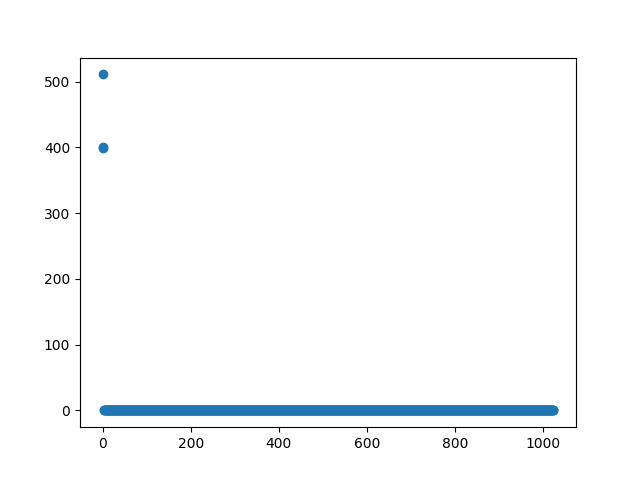

In [11]:
figure()
plot(plan.dms,'o')

In [12]:
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

INFO:craco.search_pipeline:2636 2677 2664
INFO:craco.search_pipeline:(180214,)


Kernel krnl_ddgrid_reader_4cu:krnl_ddgrid_reader_4cu_1 has groups
GID=0=32
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=15
Kernel krnl_grid_4cu:krnl_grid_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=6
Kernel krnl_grid_4cu:krnl_grid_4cu_2 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=7
Kernel krnl_grid_4cu:krnl_grid_4cu_3 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=20
Kernel krnl_grid_4cu:krnl_grid_4cu_4 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=21
Kernel fft2d:fft2d_1 has groups
Kernel fft2d:fft2d_2 has groups
Kernel fft2d:fft2d_3 has groups
Kernel fft2d:fft2d_4 has groups
Kernel krnl_boxc_4cu:krnl_boxc_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=54
GID=4=54
GID=5=4
Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups

INFO:craco.search_pipeline:lut.shape (180214,)
INFO:craco.search_pipeline:nuv 5272
INFO:craco.search_pipeline:Allocating grid LUTs
INFO:craco.search_pipeline:Allocating FDMT Input
INFO:craco.search_pipeline:5272
INFO:craco.search_pipeline:256
INFO:craco.search_pipeline:32
INFO:craco.search_pipeline:8
INFO:craco.search_pipeline:659
INFO:craco.search_pipeline:186
INFO:craco.search_pipeline:FDMT input buffer size 164.75 MB
INFO:craco.search_pipeline:Allocating FDMT history



GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14
Allocated 360428 bytes flags=flags.normal groupid=6 address=0x60000000
Allocated 360428 bytes flags=flags.normal groupid=7 address=0x70000000
Allocated 360428 bytes flags=flags.normal groupid=20 address=0x140000000
Allocated 360428 bytes flags=flags.normal groupid=21 address=0x150000000
Allocated 172752896 bytes flags=flags.normal groupid=52 address=0x90000000
Allocated 268435456 bytes flags=flags.normal groupid=53 address=0xa0000000


INFO:craco.search_pipeline:Allocating mainbuf
INFO:craco.search_pipeline:FDMT output buffer size 10.286819458007812 GB
INFO:craco.search_pipeline:Mainbuf shape is (659, 186, 11, 256, 8, 2) breaking into 8 buffers of [83, 186, 11, 256, 8, 2]


Allocated 653728 bytes flags=flags.normal groupid=14 address=0xe0000000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x4000000000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x4052eb4000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x40a5d68000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x40f8c1c000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x414bad0000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x419e984000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x41f1838000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x42446ec000


INFO:craco.search_pipeline:Allocating ddreader_lut
INFO:craco.search_pipeline:Allocating boxcar_history


Allocated 8192 bytes flags=flags.normal groupid=15 address=0xf0000000
Allocated 939524096 bytes flags=flags.normal groupid=54 address=0x0


INFO:craco.search_pipeline:Boxcar history (1024, 7, 256, 256) 939524096 2
INFO:craco.search_pipeline:Allocating candidates


Allocated 1048576 bytes flags=flags.normal groupid=4 address=0x40000000


In [13]:
from Visibility_injector.inject_in_fake_data import FakeVisibility
fvfile = '/data/craco/gup037/test_runs_of_craco_pipeline/injections/repitetive_dm_401_injection.yml'
fv = FakeVisibility(plan, fvfile)
fvblk = fv.get_fake_data_block()
nblk = 12

Visbility_injector - INFO: Loading the injection param file
INFO:Visbility_injector:Loading the injection param file
Visbility_injector - INFO: plan.shape = (190, 256, 256), Amp ratio = 0.07254762501100116
INFO:Visbility_injector:plan.shape = (190, 256, 256), Amp ratio = 0.07254762501100116


THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CHANGED CODEEEEE
THIS IS THE CH

In [14]:
cat $fvfile

add_noise: false
furby_props:
- dm_samps: 401.0
  noise_per_sample: 1.0
  shape: tophat
  snr: 20.0
  spectrum: flat
  subsample_phase: 0.5
  tau0: 1.0e-16
  width_samps: 0.01
- dm_samps: 401.0
  noise_per_sample: 1.0
  shape: tophat
  snr: 20.0
  spectrum: flat
  subsample_phase: 0.5
  tau0: 1.0e-16
  width_samps: 0.01
- dm_samps: 401.0
  noise_per_sample: 1.0
  shape: tophat
  snr: 20.0
  spectrum: flat
  subsample_phase: 0.5
  tau0: 1.0e-16
  width_samps: 0.01
- dm_samps: 401.0
  noise_per_sample: 1.0
  shape: tophat
  snr: 20.0
  spectrum: flat
  subsample_phase: 0.5
  tau0: 1.0e-16
  width_samps: 0.01
- dm_samps: 401.0
  noise_per_sample: 1.0
  shape: tophat
  snr: 20.0
  spectrum: flat
  subsample_phase: 0.5
  tau0: 1.0e-16
  width_samps: 0.01
- dm_samps: 401.0
  noise_per_sample: 1.0
  shape: tophat
  snr: 20.0
  spectrum: flat
  subsample_phase: 0.5
  tau0: 1.0e-16
  width_samps: 0.01
- dm_samps: 401.0
  noise_per_sample: 1.0
  shape: tophat
  snr: 20.0
  spectrum: flat
  subsa

In [15]:
inblocks = [next(fvblk) for i in range(nblk)]

Visbility_injector - INFO: Simulating 0th furby with params:
{'shape': 'tophat', 'spectrum_type': 'flat', 'dmsmear': True, 'subsample_phase': 0.5, 'noise_per_sample': 1.0, 'tfactor': 100, 'tot_nsamps': None, 'scattering_index': 4.4, 'snr': 20.0, 'width': 1.7e-05, 'dm': 198.13585228849666, 'tau0': 1e-16}
INFO:Visbility_injector:Simulating 0th furby with params:
{'shape': 'tophat', 'spectrum_type': 'flat', 'dmsmear': True, 'subsample_phase': 0.5, 'noise_per_sample': 1.0, 'tfactor': 100, 'tot_nsamps': None, 'scattering_index': 4.4, 'snr': 20.0, 'width': 1.7e-05, 'dm': 198.13585228849666, 'tau0': 1e-16}
Visbility_injector - INFO: Block ID: 0, start_samp = 0, end_samp = 256
INFO:Visbility_injector:Block ID: 0, start_samp = 0, end_samp = 256
Visbility_injector - INFO: Injection will start in this block
INFO:Visbility_injector:Injection will start in this block
Visbility_injector - INFO: injection_start_samp_within_block = 2
INFO:Visbility_injector:injection_start_samp_within_block = 2
Visbil

PIxel values =  [[129. 129.]]
DIRCOS here [[-0.  0.  1.]]


Visbility_injector - INFO: Block ID: 1, start_samp = 256, end_samp = 512
INFO:Visbility_injector:Block ID: 1, start_samp = 256, end_samp = 512
Visbility_injector - INFO: injection_start_samp_within_block = 0
INFO:Visbility_injector:injection_start_samp_within_block = 0
Visbility_injector - INFO: injection_end_samp_within_block = 244
INFO:Visbility_injector:injection_end_samp_within_block = 244
Visbility_injector - INFO: This was the last block which had a section of the frb, now onto the next one
INFO:Visbility_injector:This was the last block which had a section of the frb, now onto the next one
Visbility_injector - INFO: Simulating 1th furby with params:
{'shape': 'tophat', 'spectrum_type': 'flat', 'dmsmear': True, 'subsample_phase': 0.5, 'noise_per_sample': 1.0, 'tfactor': 100, 'tot_nsamps': None, 'scattering_index': 4.4, 'snr': 20.0, 'width': 1.7e-05, 'dm': 198.13585228849666, 'tau0': 1e-16}
INFO:Visbility_injector:Simulating 1th furby with params:
{'shape': 'tophat', 'spectrum_typ

PIxel values =  [[129. 129.]]
DIRCOS here [[-0.  0.  1.]]


Visbility_injector - INFO: New injection samp will be 514
INFO:Visbility_injector:New injection samp will be 514
Visbility_injector - INFO: Block ID: 2, start_samp = 512, end_samp = 768
INFO:Visbility_injector:Block ID: 2, start_samp = 512, end_samp = 768
Visbility_injector - INFO: Injection will start in this block
INFO:Visbility_injector:Injection will start in this block
Visbility_injector - INFO: injection_start_samp_within_block = 2
INFO:Visbility_injector:injection_start_samp_within_block = 2
Visbility_injector - INFO: injection_end_samp_within_block = 256
INFO:Visbility_injector:injection_end_samp_within_block = 256
Visbility_injector - INFO: Block ID: 3, start_samp = 768, end_samp = 1024
INFO:Visbility_injector:Block ID: 3, start_samp = 768, end_samp = 1024
Visbility_injector - INFO: injection_start_samp_within_block = 0
INFO:Visbility_injector:injection_start_samp_within_block = 0
Visbility_injector - INFO: injection_end_samp_within_block = 244
INFO:Visbility_injector:injectio

PIxel values =  [[129. 129.]]
DIRCOS here [[-0.  0.  1.]]


Visbility_injector - INFO: Block ID: 5, start_samp = 1280, end_samp = 1536
INFO:Visbility_injector:Block ID: 5, start_samp = 1280, end_samp = 1536
Visbility_injector - INFO: injection_start_samp_within_block = 0
INFO:Visbility_injector:injection_start_samp_within_block = 0
Visbility_injector - INFO: injection_end_samp_within_block = 244
INFO:Visbility_injector:injection_end_samp_within_block = 244
Visbility_injector - INFO: This was the last block which had a section of the frb, now onto the next one
INFO:Visbility_injector:This was the last block which had a section of the frb, now onto the next one
Visbility_injector - INFO: Simulating 3th furby with params:
{'shape': 'tophat', 'spectrum_type': 'flat', 'dmsmear': True, 'subsample_phase': 0.5, 'noise_per_sample': 1.0, 'tfactor': 100, 'tot_nsamps': None, 'scattering_index': 4.4, 'snr': 20.0, 'width': 1.7e-05, 'dm': 198.13585228849666, 'tau0': 1e-16}
INFO:Visbility_injector:Simulating 3th furby with params:
{'shape': 'tophat', 'spectrum

PIxel values =  [[129. 129.]]
DIRCOS here [[-0.  0.  1.]]


Visbility_injector - INFO: Block ID: 7, start_samp = 1792, end_samp = 2048
INFO:Visbility_injector:Block ID: 7, start_samp = 1792, end_samp = 2048
Visbility_injector - INFO: injection_start_samp_within_block = 0
INFO:Visbility_injector:injection_start_samp_within_block = 0
Visbility_injector - INFO: injection_end_samp_within_block = 244
INFO:Visbility_injector:injection_end_samp_within_block = 244
Visbility_injector - INFO: This was the last block which had a section of the frb, now onto the next one
INFO:Visbility_injector:This was the last block which had a section of the frb, now onto the next one
Visbility_injector - INFO: Simulating 4th furby with params:
{'shape': 'tophat', 'spectrum_type': 'flat', 'dmsmear': True, 'subsample_phase': 0.5, 'noise_per_sample': 1.0, 'tfactor': 100, 'tot_nsamps': None, 'scattering_index': 4.4, 'snr': 20.0, 'width': 1.7e-05, 'dm': 198.13585228849666, 'tau0': 1e-16}
INFO:Visbility_injector:Simulating 4th furby with params:
{'shape': 'tophat', 'spectrum

PIxel values =  [[129. 129.]]
DIRCOS here [[-0.  0.  1.]]


Visbility_injector - INFO: Block ID: 9, start_samp = 2304, end_samp = 2560
INFO:Visbility_injector:Block ID: 9, start_samp = 2304, end_samp = 2560
Visbility_injector - INFO: injection_start_samp_within_block = 0
INFO:Visbility_injector:injection_start_samp_within_block = 0
Visbility_injector - INFO: injection_end_samp_within_block = 244
INFO:Visbility_injector:injection_end_samp_within_block = 244
Visbility_injector - INFO: This was the last block which had a section of the frb, now onto the next one
INFO:Visbility_injector:This was the last block which had a section of the frb, now onto the next one
Visbility_injector - INFO: Simulating 5th furby with params:
{'shape': 'tophat', 'spectrum_type': 'flat', 'dmsmear': True, 'subsample_phase': 0.5, 'noise_per_sample': 1.0, 'tfactor': 100, 'tot_nsamps': None, 'scattering_index': 4.4, 'snr': 20.0, 'width': 1.7e-05, 'dm': 198.13585228849666, 'tau0': 1e-16}
INFO:Visbility_injector:Simulating 5th furby with params:
{'shape': 'tophat', 'spectrum

PIxel values =  [[129. 129.]]
DIRCOS here [[-0.  0.  1.]]


Visbility_injector - INFO: Block ID: 11, start_samp = 2816, end_samp = 3072
INFO:Visbility_injector:Block ID: 11, start_samp = 2816, end_samp = 3072
Visbility_injector - INFO: injection_start_samp_within_block = 0
INFO:Visbility_injector:injection_start_samp_within_block = 0
Visbility_injector - INFO: injection_end_samp_within_block = 244
INFO:Visbility_injector:injection_end_samp_within_block = 244
Visbility_injector - INFO: This was the last block which had a section of the frb, now onto the next one
INFO:Visbility_injector:This was the last block which had a section of the frb, now onto the next one
Visbility_injector - INFO: Simulating 6th furby with params:
{'shape': 'tophat', 'spectrum_type': 'flat', 'dmsmear': True, 'subsample_phase': 0.5, 'noise_per_sample': 1.0, 'tfactor': 100, 'tot_nsamps': None, 'scattering_index': 4.4, 'snr': 20.0, 'width': 1.7e-05, 'dm': 198.13585228849666, 'tau0': 1e-16}
INFO:Visbility_injector:Simulating 6th furby with params:
{'shape': 'tophat', 'spectr

PIxel values =  [[129. 129.]]
DIRCOS here [[-0.  0.  1.]]


In [16]:
inblocks = np.array(inblocks)

In [17]:
inblocks.shape

(12, 190, 256, 256)

In [18]:
inblocksum = inblocks.sum(axis=(1,2,3))
inblocksum.reshape(-1,2)

array([[3307.8796+0.j, 3165.8508+0.j],
       [3307.8796+0.j, 3165.8508+0.j],
       [3307.8796+0.j, 3165.8508+0.j],
       [3307.8796+0.j, 3165.8508+0.j],
       [3307.8796+0.j, 3165.8508+0.j],
       [3307.8796+0.j, 3165.8508+0.j]], dtype=complex64)

In [19]:
assert np.all(inblocks[::2, ...] == inblocks[0,...])
assert np.all(inblocks[1::2, ...] == inblocks[1,...])

In [20]:
p.clear_buffers(values)
values.run_fdmt = True
values.run_image = True
values.threshold = 10
values.input_scale = 64
values.fft_scale1 = 2
cands = []
idm  = 400
pix = 0

bchist = []
mbhist = []

mb0 = p.all_mainbufs[6]

for iblk in range(nblk):
    p.copy_input(inblocks[iblk,...], values)
    p.run(iblk, values).wait()
    cands.append(p.get_candidates().copy())
    print(f'Got {len(cands[-1])} candidates')
    p.boxcar_history.copy_from_device()
    bchist.append(p.boxcar_history.nparr[idm,:,128,128].copy())
    #p.[83, 186, 11, 256, 8, 2]
    mb0.copy_from_device()
    mbhist.append(mb0.nparr[0,:,:,:,0,0].copy())
    
    
        

INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11
INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 0 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 191 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 4 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 191 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 4 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 191 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 4 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 191 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 4 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 191 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 4 candidates


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=3 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=96 threshold=640 shift1=0 shift2=7 fft_cfg=6001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 191 candidates


In [21]:
bchist = np.array(bchist)
mbhist = np.array(mbhist)

In [22]:
[len(c) for c in cands]

[0, 191, 4, 191, 4, 191, 4, 191, 4, 191, 4, 191]

In [23]:
maxcand = [max(c, key=lambda x: x['snr']) for c in cands if len(c) != 0]
maxcand

[(9453, 0, 1, 241, 1),
 (749, 0, 7, 43, 2),
 (9453, 0, 1, 241, 1),
 (749, 0, 7, 43, 2),
 (9453, 0, 1, 241, 1),
 (749, 0, 7, 43, 2),
 (9453, 0, 1, 241, 1),
 (749, 0, 7, 43, 2),
 (9453, 0, 1, 241, 1),
 (749, 0, 7, 43, 2),
 (9453, 0, 1, 241, 1)]

In [24]:
maxcand[0].dtype

dtype([('snr', '<i2'), ('loc_2dfft', '<u2'), ('boxc_width', 'u1'), ('time', 'u1'), ('dm', '<u2')])

<IPython.core.display.Javascript object>


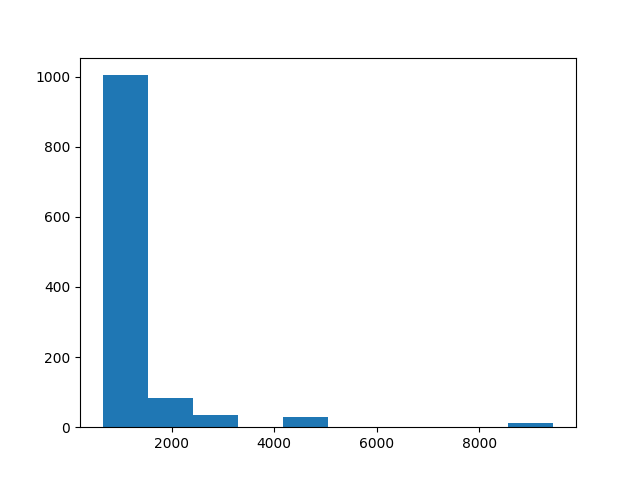

(array([1004.,   84.,   36.,    0.,   30.,    0.,    0.,    0.,    0.,
          12.]),
 array([ 645. , 1525.8, 2406.6, 3287.4, 4168.2, 5049. , 5929.8, 6810.6,
        7691.4, 8572.2, 9453. ]),
 <BarContainer object of 10 artists>)

In [25]:
all_cands = []
for c in cands:
    all_cands.extend(c)
    
snrs = [c['snr'] for c in all_cands]
figure()
hist(snrs)

In [26]:
mbhist.shape

(12, 186, 11, 256)

<IPython.core.display.Javascript object>


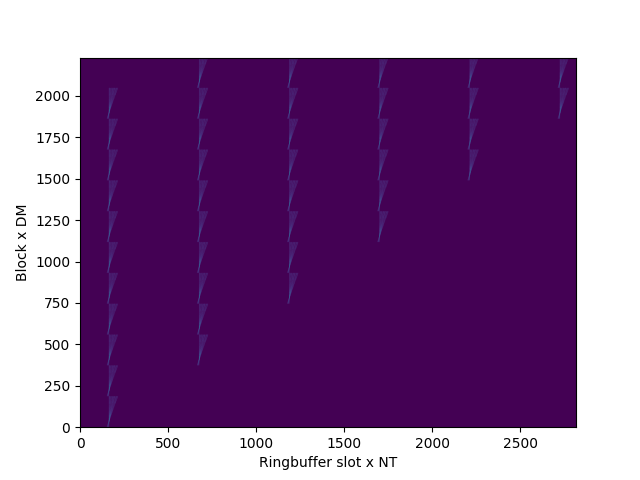

Text(0, 0.5, 'Block x DM')

In [27]:
figure()
imshow(mbhist.reshape(12*186,-1), aspect='auto', origin='lower')
xlabel('Ringbuffer slot x NT')
ylabel('Block x DM')

In [28]:
import craco_pybind11
import craco_pybind11.ddgrid_reader
import craco_pybind11.grid
import craco_pybind11.fdmt_tunable

nchunk_time = plan.nchunk_time
nparallel_uvin, nparallel_uvout, h_nparallel_uvout, lut = get_grid_lut_from_plan(plan)
nuvrest = nparallel_uvin*2//8
NUVWIDE = 8
OUTPUT_NT = 2
OUTPUT_NUV = 2
ncu = 4
ndm = plan.nd
tblk = 0
do_load_lut = 1

In [29]:
craco_pybind11.fdmt_tunable.NTBLK_OUTBUF

11

In [30]:
craco_pybind11.krnl.NT

256

In [31]:
tblks = (9,10,0)

outputs = np.zeros((len(tblks), ncu, ndm, nchunk_time, nuvrest, NUVWIDE//OUTPUT_NUV, OUTPUT_NT, OUTPUT_NUV, 2), dtype=np.int16)

In [32]:
mainbuf = p.copy_mainbuf()

In [33]:

for itblk, tblk in enumerate(tblks):
    craco_pybind11.ddgrid_reader.krnl_ddgrid_reader_4cu(mainbuf, 
                                     ndm, 
                                     tblk,
                                     nchunk_time, 
                                     nuvrest, 
                                     plan.ddreader_lut, 
                                     do_load_lut, 
                                     outputs[itblk, 0], 
                                     outputs[itblk, 1], 
                                     outputs[itblk, 2], 
                                     outputs[itblk, 3])

In [34]:
plan.nd

3

In [35]:
outputs.shape

(3, 4, 3, 32, 659, 4, 2, 2, 2)

In [36]:
transposeidxs = [0, 3,1,6,2,4,5,7,8]
outputsrs = outputs.copy().transpose(transposeidxs)
outputsrs.shape

(3, 32, 4, 2, 3, 659, 4, 2, 2)

In [37]:
s = np.array(outputsrs.shape)

outputsrs = outputsrs.reshape(s[0], s[1:4].prod(),s[4],s[5:8].prod(),s[8])
outputsrs.shape

(3, 256, 3, 5272, 2)

In [38]:
np.all(outputs == 0)

False

In [39]:
np.all(outputsrs == 0)

False

In [40]:
craco_pybind11.krnl.NT

256

In [41]:
craco_pybind11.krnl.NUVWIDE

8

In [42]:
np.all(outputsrs[0,...] == outputsrs[2,...])

True

<IPython.core.display.Javascript object>


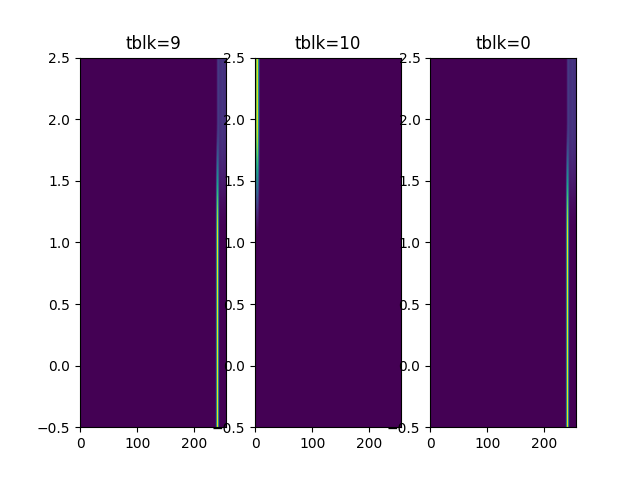

In [43]:
fig, ax = subplots(1,len(tblks))
for itblk, tblk in enumerate(tblks):
    ax[itblk].imshow(outputsrs[itblk,:,:,0,0].T, aspect='auto', origin='lower')
    ax[itblk].set_title(f'tblk={tblk}')

In [44]:
outputsrs.shape

(3, 256, 3, 5272, 2)

<IPython.core.display.Javascript object>


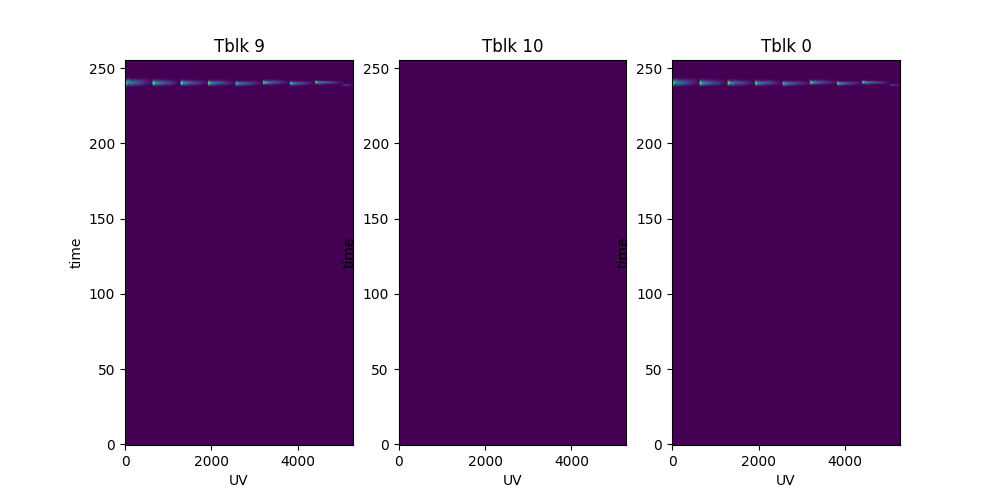

In [45]:
fig, ax = subplots(1,len(tblks))
fig.set_size_inches((10,5))
for itblk, tblk in enumerate(tblks):
    ax[itblk].imshow(outputsrs[itblk,:,1,:,0], aspect='auto', origin='lower')
    ax[itblk].set_title(f'Tblk {tblk}')
    ax[itblk].set_xlabel('UV')
    ax[itblk].set_ylabel('time')
    
         

In [46]:
outputsrs.shape

(3, 256, 3, 5272, 2)

In [47]:
outputsrs.shape[-2]/2

2636.0

<IPython.core.display.Javascript object>


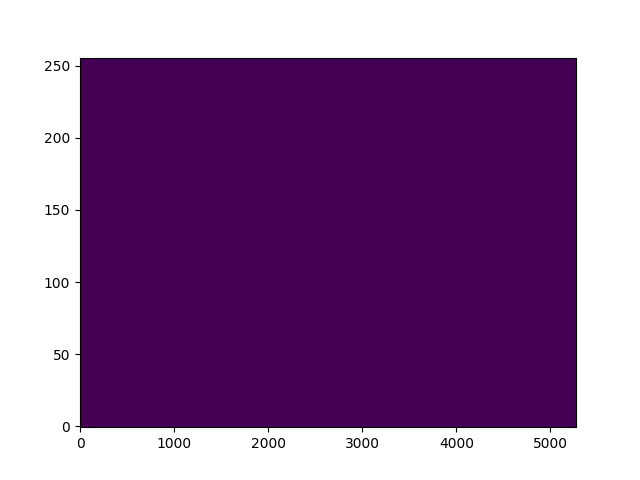

In [48]:
figure()
imshow(outputsrs[0,:,1,:,0]-outputsrs[2,:,1,:,0], aspect='auto', origin='lower')

In [49]:
mainbuf.shape

(664, 186, 11, 256, 8, 2)

<IPython.core.display.Javascript object>


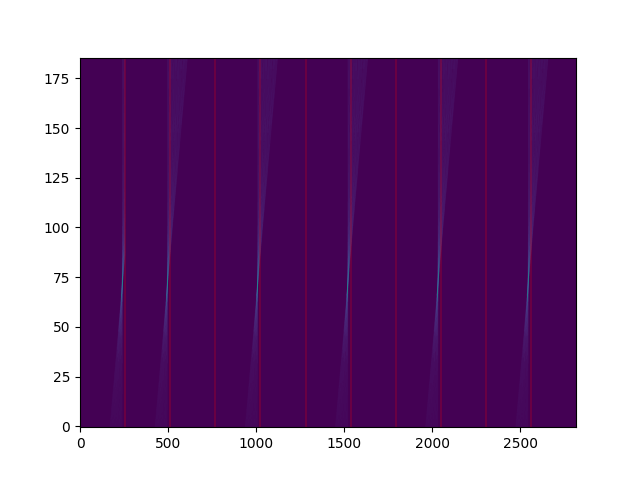

In [50]:
figure()
imshow(mainbuf[0,:,:,:,0,0].reshape(186,-1), aspect='auto', origin='lower')
for b in range(11):
    axvline(b*256,c='r', alpha=0.2)

In [51]:
mainbufrs = mainbuf[0:1,...].transpose([0,4,1,2,3,5]).reshape(-1,186,11*256,2)
mainbufrs.shape

(8, 186, 2816, 2)

<IPython.core.display.Javascript object>


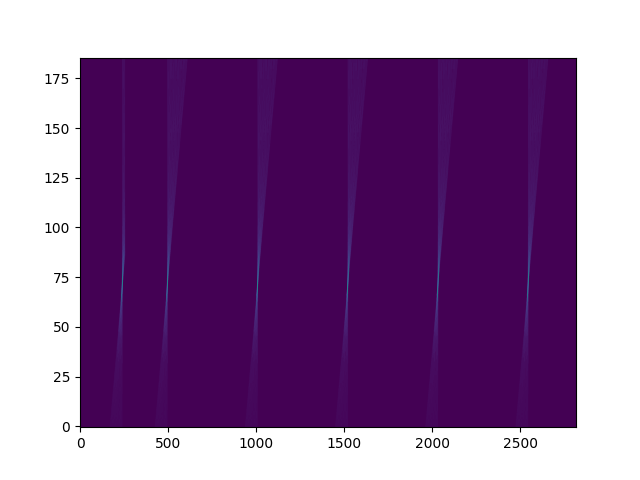

In [52]:
figure()
imshow(mainbufrs[0,:,:,0],aspect='auto',origin='lower')

In [53]:
from craco_pybind11.ddgrid_reader import load_luts

luts_large = load_luts(plan_large.ddreader_lut[:-1])
luts_large

In [54]:
luts_small = load_luts(plan_small.ddreader_lut[:-1])
luts_small

In [55]:
from craco_pybind11.ddgrid_reader import calc_indexs
dmidx = 400
uvrest = 0
r = calc_indexs(dmidx, uvrest, luts_large)
print(f"IDM={r.idm} tback={r.tback} for idm={plan_large.dms[dmidx]}")

IDM=73 tback=0 for idm=400


In [56]:
dmidx = 2
r = calc_indexs(dmidx, uvrest,luts_small)
print(f"IDM={r.idm} tback={r.tback} for idm={plan_small.dms[dmidx]}")

IDM=93 tback=0 for idm=511


In [57]:

plan_small.dms[1:2]

array([400], dtype=uint32)

<IPython.core.display.Javascript object>


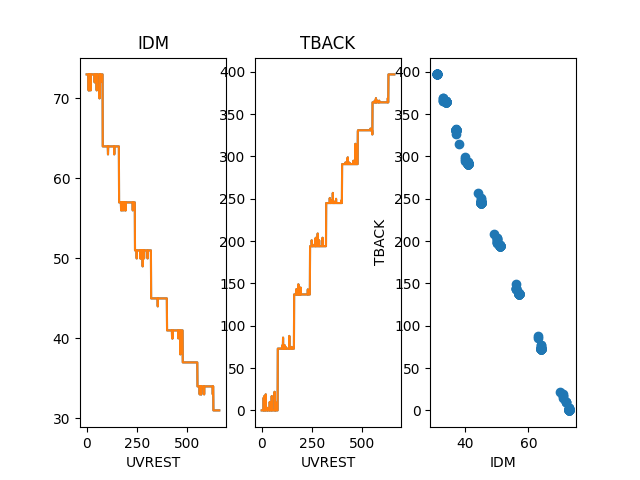

1 400 400 400


In [58]:
fig, ax = subplots(1,3)
for _, small_dm in enumerate(plan_small.dms[1:2]):
    small_dmidx = np.where(plan_small.dms == small_dm)[0][0]
    large_dmidx = np.where(plan_large.dms == small_dm)[0][0]
    print(small_dmidx, plan_small.dms[small_dmidx], large_dmidx, plan_large.dms[large_dmidx])
    assert plan_small.dms[small_dmidx] == plan_large.dms[large_dmidx]
    idx_small = [calc_indexs(small_dmidx, u, luts_small) for u in range(plan.nuvrest)]
    idx_large = [calc_indexs(large_dmidx, u, luts_large) for u in range(plan.nuvrest)]
    idx_all = np.array([(r1.idm, r2.idm, r1.tback, r2.tback) for (r1, r2) in zip(idx_small, idx_large)])
    ax[0].plot(idx_all[:,0])
    ax[0].plot(idx_all[:,1])
    ax[1].plot(idx_all[:,2])
    ax[1].plot(idx_all[:,3])
    ax[2].scatter(idx_all[:,0], idx_all[:,2])
    ax[0].set_title('IDM')
    ax[1].set_title('TBACK')
    ax[2].set_xlabel('IDM')
    ax[2].set_ylabel('TBACK')
    ax[0].set_xlabel('UVREST')
    ax[1].set_xlabel('UVREST')
    assert np.all(idx_all[:,0] == idx_all[:,1])
    assert np.all(idx_all[:,2] == idx_all[:,3])

<IPython.core.display.Javascript object>


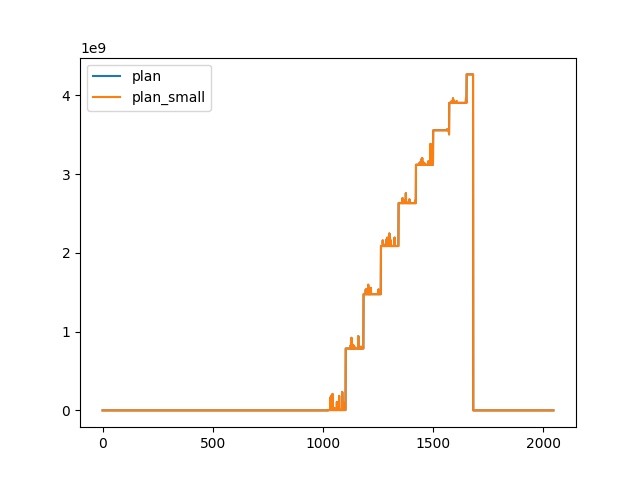

In [59]:
figure()
plot(plan.ddreader_lut, label='plan');
plot(plan_small.ddreader_lut-plan_large.ddreader_lut*0, label='plan_small');
legend()

In [60]:
from craco_pybind11.ddgrid_reader import calc_burst_parameters
calc_burst_parameters?

In [61]:
tblk = 0
tchunk = 0
idx_small = [calc_indexs(small_dmidx, u, luts_small) for u in range(plan.nuvrest)]
burst_params = [calc_burst_parameters(idx.idm, idx.tback, tblk, tchunk, u) for u, idx in enumerate(idx_small)]

In [62]:
uvrest = 320
idx_small[uvrest].tback

245

In [63]:
idx_small[uvrest].idm

45

In [64]:
b = burst_params[uvrest]

In [65]:
for f in dir(b):
    if not f.startswith('__'):
        print(f, getattr( b,f))
tmod = (b.idx1 - b.idx_bufstart)*2
tmod

aligned False
idx1 83868805
idx_bufstart 83867520
nread1 5
nread2 0


2570

In [66]:
mainbuf.shape

(664, 186, 11, 256, 8, 2)

In [67]:
np.ravel_multi_index((320,45,0,0,0,0), mainbuf.shape)//16//2

83867520

In [68]:
burst_idx1 = np.array([b.idx1 for b in burst_params])
burst_aligned = np.array([b.aligned for b in burst_params])
burst_idx_bufstart = np.array([b.idx_bufstart for b in burst_params])
burst_nread1 = np.array([b.nread1 for b in burst_params])
burst_nread2 = np.array([b.nread2 for b in burst_params])

<IPython.core.display.Javascript object>


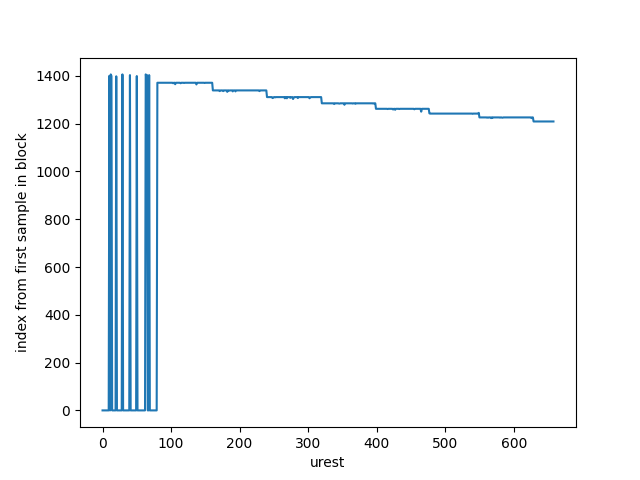

Text(0.5, 0, 'urest')

In [69]:
figure()
plot(burst_idx1-burst_idx_bufstart)
ylabel('index from first sample in block')
xlabel('urest')

# well that doesn't look right - it wraps to 1285 - shouldn't it wrap to twice that number?

In [70]:
u = 320
tblk = 0
idx = idx_small[u]
burst_params = [calc_burst_parameters(idx.idm, idx.tback, tblk, tchunk, u) for tchunk in range(32)]
burst_idx1 = np.array([b.idx1 for b in burst_params])
burst_aligned = np.array([b.aligned for b in burst_params])
burst_idx_bufstart = np.array([b.idx_bufstart for b in burst_params])
burst_nread1 = np.array([b.nread1 for b in burst_params])
burst_nread2 = np.array([b.nread2 for b in burst_params])

In [71]:
idx.tback

245

<IPython.core.display.Javascript object>


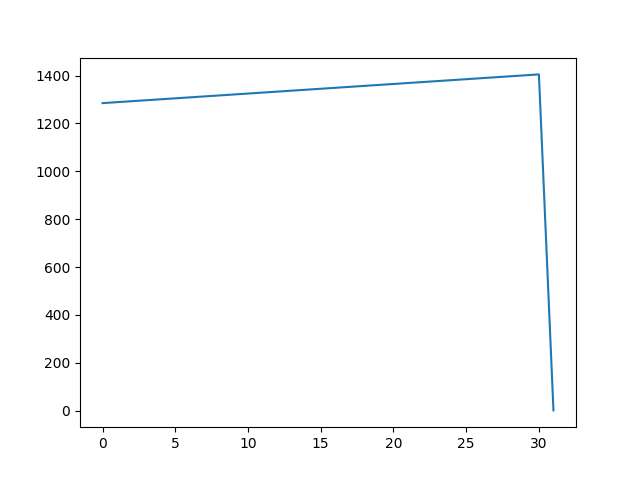

In [72]:
figure()
plot(burst_idx1 - burst_idx_bufstart)

In [73]:
assert np.all(burst_idx_bufstart == burst_idx_bufstart[0])

In [74]:
plan_small.dms

array([399, 400, 511, ...,   0,   0,   0], dtype=uint32)

<IPython.core.display.Javascript object>


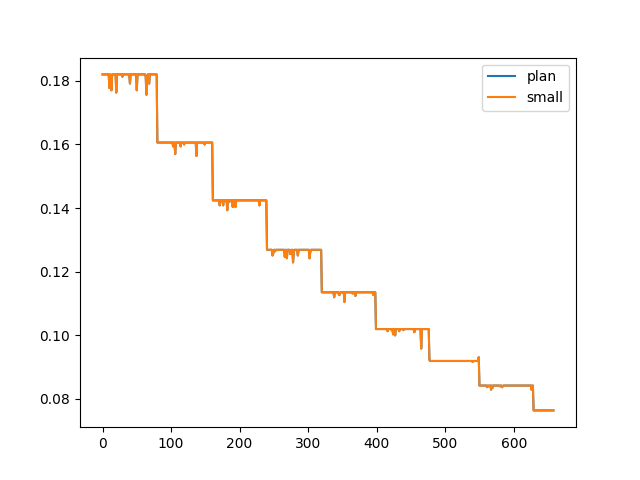

In [75]:
idm = [run.idm_cff for run  in plan.fdmt_plan.runs]
idm_small = [run.idm_cff for run in  plan_small.fdmt_plan.runs]
figure()
plot(idm, label='plan')
plot(idm_small, label='small')
legend()

<IPython.core.display.Javascript object>


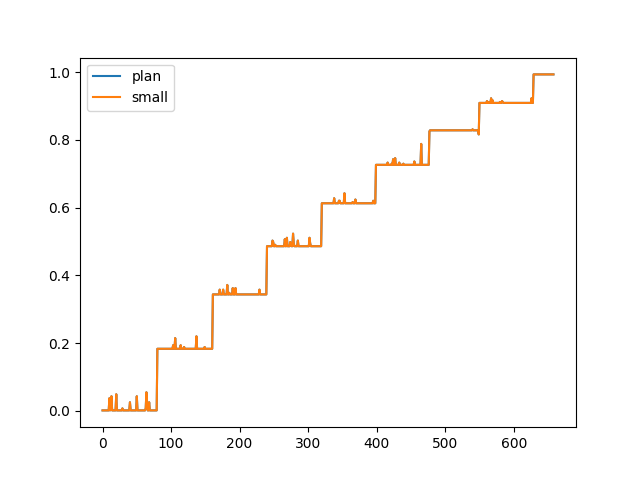

In [76]:
off = [run.offset_cff for run  in plan.fdmt_plan.runs]
off_small = [run.offset_cff for run in  plan_small.fdmt_plan.runs]
figure()
plot(off, label='plan')
plot(off_small, label='small')
legend()

In [77]:
craco_pybind11.krnl.NUREST

1023

In [78]:
craco_pybind11.krnl.MAX_NDM

1024